<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/Camadas_Lineares_Ativacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camadas Lineares e Funções de Ativação



## Camadas Lineares

## Funções de Ativação

Após as operações de cada camada linear, costuma-se uma função de ativação não linear para permitir que a rede aprenda representações complexas. As redes neurais iniciais faziam muito uso das funções de ativação Sigmóide e Tangente Hiperbólica. Porém, nas redes neurais profundas, a função de ativação mais utilizada é a ReLU (Rectified Linear Unit), que é simples, eficiente e reduz o problema do gradiente desaparecendo. Uma variação desta última é a Leaky ReLU, que mantém um pequeno valor negativo para entradas menores que zero, evitando o problema dos neurônios “mortos” que nunca ativam. Mais recentemente, a GeLU (Gaussian Error Linear Unit) tem sido usada em arquiteturas avançadas, pois suaviza a transição entre valores negativos e positivos com base em uma função probabilística, oferecendo melhor desempenho em alguns cenários, especialmente em modelos de larga escala.

### ReLU

A função de ativação ReLU (Naim & Hinton, 2010), popularizada com a AlexNet (Krizhevsky et al, 2012), é uma das mais utilizadas em redes neurais modernas devido à sua simplicidade e eficácia. Sua fórmula é
$f(x)=\text{max}(0,x)$ , o que significa que ela transforma valores negativos em zero, enquanto mantém valores positivos inalterados. Isso introduz não-linearidade na rede, permitindo que ela aprenda padrões complexos. Comparada a funções de ativação anteriores, como sigmoid e tanh, a ReLU tem a vantagem de ser computacionalmente mais eficiente e de mitigar o problema do desvanecimento do gradiente, uma vez que seus gradientes são constantes para entradas positivas. No entanto, ReLU também pode sofrer com o problema de "neurônios mortos" quando muitas unidades se tornam zero, o que pode ser tratado com variantes como Leaky ReLU e GeLU (gaussian error linear unit).

In [1]:
import numpy as np

import matplotlib.pyplot as plt

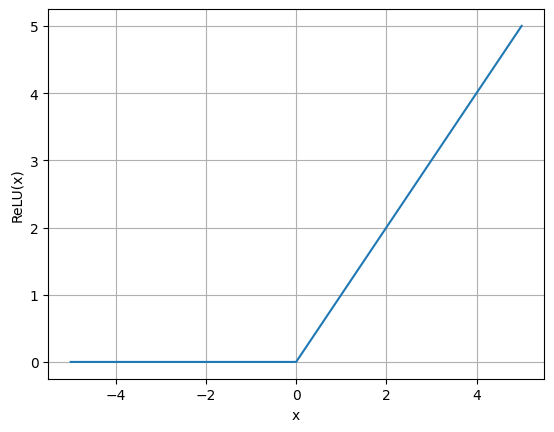

In [2]:
x = np.linspace(-5, 5, 101)
y = np.array([max(i, 0) for i in x])

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.grid()
plt.show()

### Variantes (Leaky ReLU e GeLU)

Para diminuir problemas de neurônios mortos, variantes como Leaky ReLU e GeLU possuem valores diferentes de zero quando X é negativo.
Leaky Relu, utilizando um certo valor $\alpha$, possui o formato $f(x,\alpha)=\text{max}(\alpha.x,x)$, enquanto GeLU pesa a entrada pelo quanto ela é provável de ser positiva sob uma distribuição normal padrão.

In [3]:
from scipy.special import erf

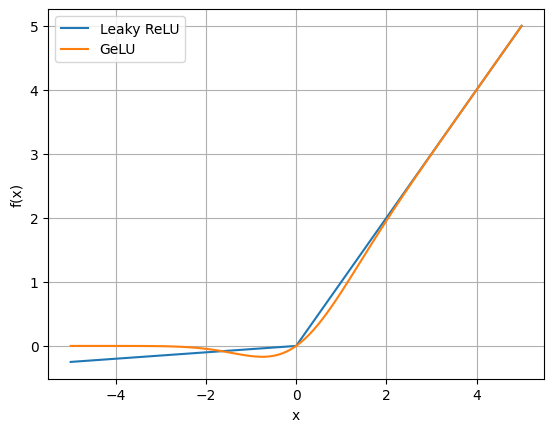

In [4]:
x = np.linspace(-5, 5, 101)

lrelu = np.array([max(i, 0.05*i) for i in x])
gelu = 0.5 * x * (1 + erf(x / np.sqrt(2)))

plt.plot(x, lrelu)
plt.plot(x, gelu)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.legend(['Leaky ReLU', 'GeLU'])
plt.show()

## Conexões Residuais

As conexões residuais foram a principal inovação da ResNet (He et al, 2016) e representam um avanço crucial no design de redes neurais profundas. Elas introduzem um atalho que permite que o sinal original da entrada seja passado diretamente para uma camada posterior, sem passar pelas camadas intermediárias, criando o que é chamado de mapeamento de identidade. Esse conceito resolve o problema do gradiente desvanecente, que dificultava o treinamento de redes muito profundas, ao garantir que os gradientes possam fluir de forma mais eficaz para as camadas anteriores. As conexões residuais permitem que a rede aprenda diferenças residuais em vez de tentar ajustar o mapeamento completo da função, o que facilita o aprendizado. Como resultado, redes muito profundas, como as versões da ResNet com 50, 101 ou até 152 camadas, podem ser treinadas de maneira eficaz, sem degradação de desempenho, permitindo que elas capturem representações complexas dos dados.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/resnet.png?raw=true"></center>

## Exemplo com redes neurais profundas

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2, non_linearity=True):
        super().__init__()
        self.non_linearity = non_linearity
        self.layers = nn.ModuleList()
        in_dim = input_size

        # Hidden layers
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(in_dim, hidden_size))
            in_dim = hidden_size

        # Output layer
        self.output_layer = nn.Linear(in_dim, 1)
        self.activation_fn = nn.LeakyReLU() if non_linearity else nn.Identity()

        # 🔧 Zero all biases
        for layer in self.layers:
            if hasattr(layer, 'bias') and layer.bias is not None:
                nn.init.zeros_(layer.bias)

        if hasattr(self.output_layer, 'bias') and self.output_layer.bias is not None:
            nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        activations = []
        for layer in self.layers:
            x = layer(x)
            if self.non_linearity:
                x = self.activation_fn(x)
            activations.append(x)
        out = self.output_layer(x)
        return out, activations

In [ ]:
import numpy as np

from sklearn.datasets import make_circles
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X, y = make_circles(n_samples=200, noise=0.1, factor=0.4, random_state=42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = MLP(input_size=X.shape[1], hidden_size=2, n_layers=5, non_linearity=True).to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from tqdm import tqdm

100%|██████████| 10000/10000 [02:34<00:00, 64.72it/s]


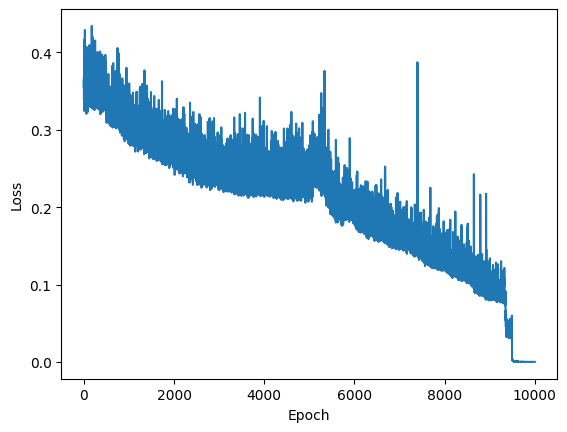

In [ ]:
num_epochs = 10_000
# num_epochs = 1000
loss_logs = []

for epoch in tqdm(range(num_epochs)):

    # Start epoch loss
    running_loss = 0.0

    for b, (X_batch, y_batch) in enumerate(dataloader):

        # Forward pass
        outputs, _ = model(X_batch.to(device))
        loss = criterion(outputs, y_batch.to(device))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Update epoch loss
    loss_logs.append(running_loss/b)

    # tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/b:.4f}")

# Plot loss
plt.plot(loss_logs)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

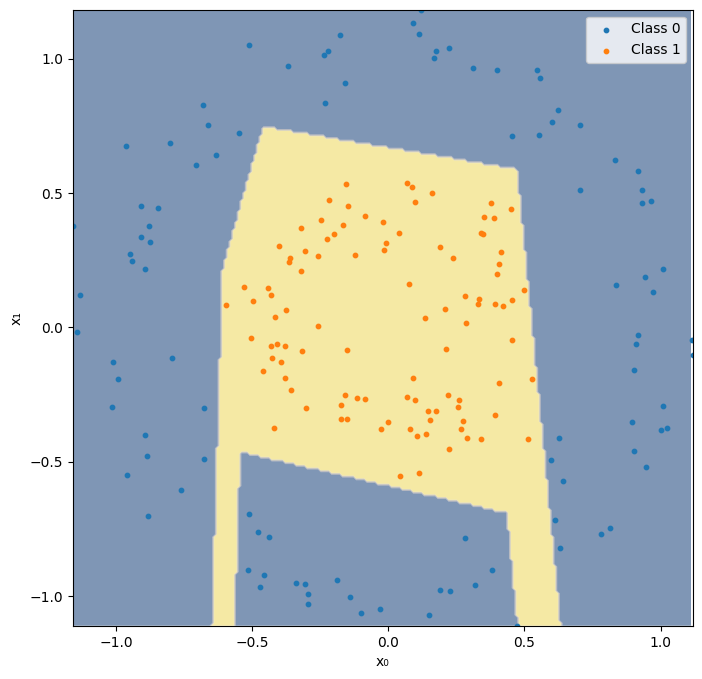

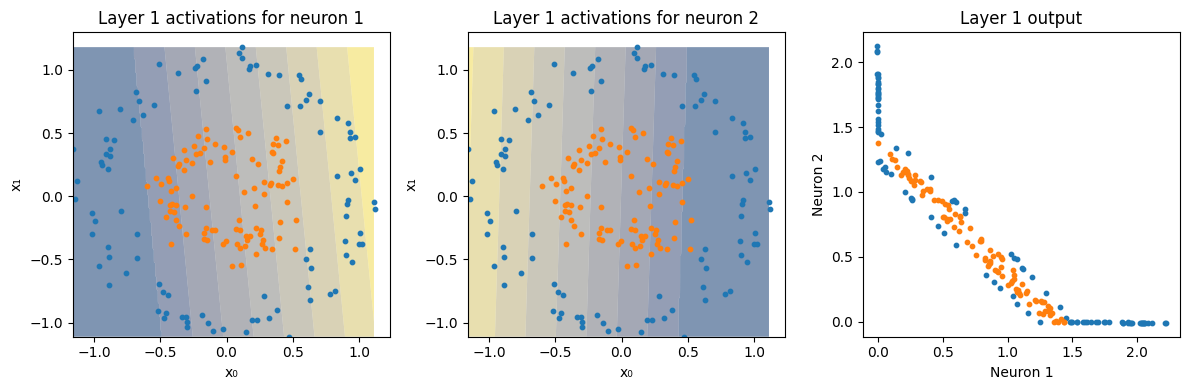

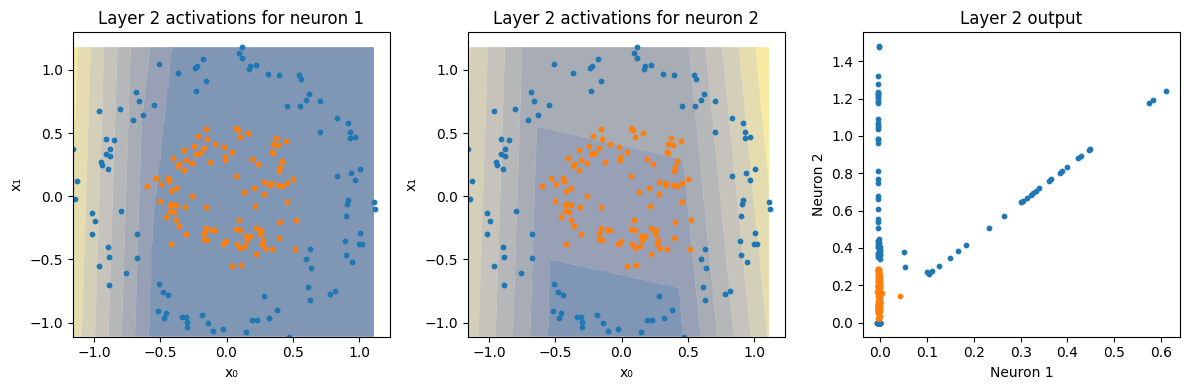

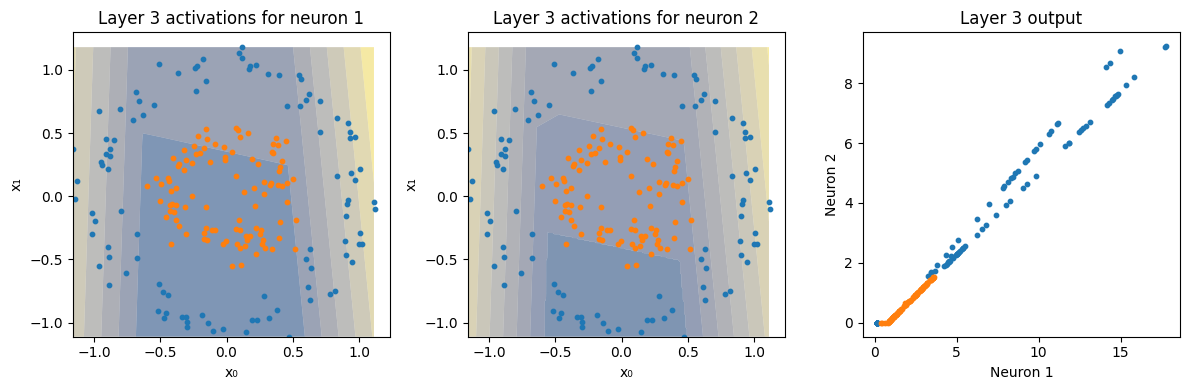

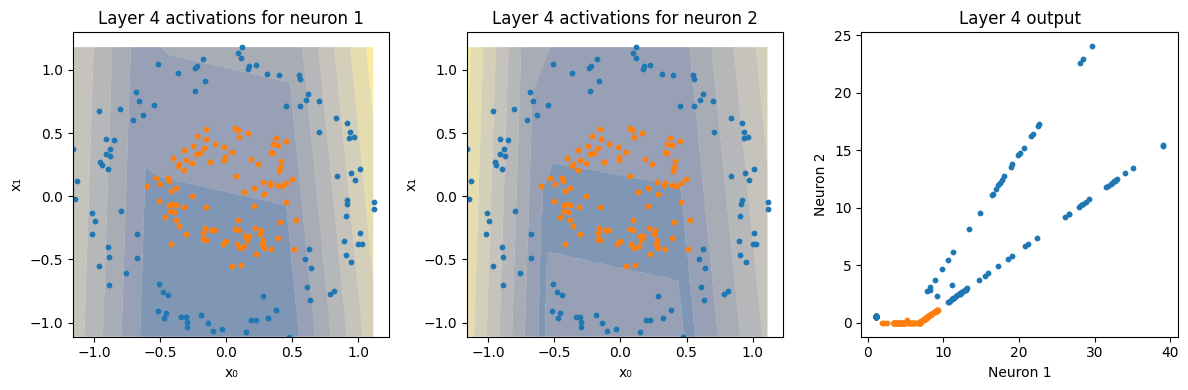

In [ ]:
@torch.no_grad()
def plot_decision_boundary(model, X, y, show_activations=False, resolution=0.01, cmap='cividis'):
    """
    Plot the decision boundary for a 2D torch model.

    Args:
        model: torch.nn.Module that outputs predictions or (pred, activations)
        X: torch.Tensor of shape (N, 2)
        y: torch.Tensor of shape (N,) or (N,1)
        show_activations: if True, also plot intermediate activations as subplots
        resolution: grid resolution for the mesh
        cmap: color map for contour plot
    """
    device = next(model.parameters()).device
    X, y = X.to(device), y.to(device)

    # Build grid
    x_min, x_max = X[:, 0].min().item(), X[:, 0].max().item()
    y_min, y_max = X[:, 1].min().item(), X[:, 1].max().item()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32, device=device)

    # Model prediction (handle models returning activations)
    output = model(grid)
    if isinstance(output, tuple):  # (y_pred, activations)
        Z, activations = output
    else:
        Z, activations = output, None

    instances_output = model(X)
    if isinstance(instances_output, tuple):  # (y_pred, activations)
        Z_instances, activations_instances = instances_output
    else:
        Z_intances, activations_instances = instances_output, None

    # Convert logits to binary predictions
    if Z.ndim > 1 and Z.shape[1] == 1:
        Z = Z.squeeze(1)
    Z = torch.sigmoid(Z) if Z.dtype.is_floating_point else Z
    Z = (Z > 0.5).float()
    Z = Z.cpu().numpy().reshape(xx.shape)

    # Main plot
    fig = plt.figure(figsize=(8, 8))
    contour = plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap, antialiased=True)
    plt.scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), s=10, label="Class 0")
    plt.scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), s=10, label="Class 1")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('x₀')
    plt.ylabel('x₁')
    plt.legend()

    # Optionally show activations
    for l, (activation, activation_instances) in enumerate(zip(activations, activations_instances)):
        n_neurons = activation.shape[1]
        fig, axes = plt.subplots(1, n_neurons + 1, figsize=(6 * n_neurons, 4))
        if n_neurons == 1:
            axes = [axes]
        a = activation.detach().cpu().numpy()
        ai = activation_instances.detach()
        for i in range(n_neurons):
            Z = a[:, i].reshape(xx.shape)  # only first neuron
            axes[i].contourf(xx, yy, Z, alpha=0.5, cmap=cmap, antialiased=True)
            axes[i].scatter(X[y == 0, 0].cpu(), X[y == 0, 1].cpu(), s=10, label="Class 0")
            axes[i].scatter(X[y == 1, 0].cpu(), X[y == 1, 1].cpu(), s=10, label="Class 1")
            axes[i].set_title(f"Layer {l+1} activations for neuron {i+1}")
            axes[i].set_xlabel('x₀')
            axes[i].set_ylabel('x₁')
        axes[i+1].scatter(ai[y == 0, 0].cpu(), ai[y == 0, 1].cpu(), s=10, label="Class 0")
        axes[i+1].scatter(ai[y == 1, 0].cpu(), ai[y == 1, 1].cpu(), s=10, label="Class 1")
        axes[i+1].set_title(f"Layer {l+1} output")
        axes[i+1].set_xlabel('Neuron 1')
        axes[i+1].set_ylabel('Neuron 2')
        plt.tight_layout()

    plt.show()

plot_decision_boundary(model, X, y[:,0], show_activations=True)